# The Wonderful World of Coffee

This notebook begins to explore the retail sales of a cars dataset scraped by one gracious
 reddit user, We will be predicting Price first, but lets see where the day takes us

The data source is below

https://github.com/jldbc/coffee-quality-database

First things first, lets import our libraries and take a peek at our data.


In [10]:
#Add library references
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [22]:
#Upload Data

df_arab = pd.read_csv('https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/arabica_data_cleaned.csv') # read in the Arabica data
df_rob = pd.read_csv('https://raw.githubusercontent.com/jldbc/coffee-quality-database/master/data/robusta_data_cleaned.csv') # read in the Robusta data
#Quick Column rename
df_arab.rename(columns={'Unnamed: 0':'Id'}, inplace=True)
df_rob.rename(columns={'Unnamed: 0':'Id'}, inplace=True)
print(df_arab.columns)


Index(['Id', 'Species', 'Owner', 'Country.of.Origin', 'Farm.Name',
       'Lot.Number', 'Mill', 'ICO.Number', 'Company', 'Altitude', 'Region',
       'Producer', 'Number.of.Bags', 'Bag.Weight', 'In.Country.Partner',
       'Harvest.Year', 'Grading.Date', 'Owner.1', 'Variety',
       'Processing.Method', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
       'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness', 'Cupper.Points',
       'Total.Cup.Points', 'Moisture', 'Category.One.Defects', 'Quakers',
       'Color', 'Category.Two.Defects', 'Expiration', 'Certification.Body',
       'Certification.Address', 'Certification.Contact', 'unit_of_measurement',
       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters'],
      dtype='object')


Now that we've got the data inputted, let's begin our EDA process by looking at our datatypes and
overall shape of the data.


In [15]:
#Arabica Stats
#print(df_arab.head().append(df_arab.tail()), "\n")
print("Structure of Arabica: ",df_arab.shape,"\n")
print("Summary Statistic's:\n",df_arab.describe(),"\n")
print("Count of missing Arabica values:\n",df_arab.isnull().sum().sort_values(ascending=False),"\n")

#Rob Stats
#print(df_rob.head().append(df_arab.tail()), "\n")
print("Structure of Robusta: ",df_rob.shape,"\n")
print("Summary Statistic's:\n",df_rob.describe(),"\n")
print("Count of missing Robusta values:\n",df_rob.isnull().sum().sort_values(ascending=False),"\n")
#df_arab.describe()
#df_rob.describe()


Structure of Cars:  (1311, 44) 

Summary Statistic's:
         Unnamed: 0  Number.of.Bags        Aroma       Flavor   Aftertaste  \
count  1311.000000     1311.000000  1311.000000  1311.000000  1311.000000   
mean    656.000763      153.887872     7.563806     7.518070     7.397696   
std     378.598733      129.733734     0.378666     0.399979     0.405119   
min       1.000000        0.000000     0.000000     0.000000     0.000000   
25%     328.500000       14.500000     7.420000     7.330000     7.250000   
50%     656.000000      175.000000     7.580000     7.580000     7.420000   
75%     983.500000      275.000000     7.750000     7.750000     7.580000   
max    1312.000000     1062.000000     8.750000     8.830000     8.670000   

           Acidity         Body      Balance   Uniformity   Clean.Cup  \
count  1311.000000  1311.000000  1311.000000  1311.000000  1311.00000   
mean      7.533112     7.517727     7.517506     9.833394     9.83312   
std       0.381599     0.359213 

,Unnamed: 0,Number.of.Bags,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,altitude_low_meters,altitude_high_meters,altitude_mean_meters
count,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.00000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1310.000000,1311.000000,1084.000000,1084.000000,1084.000000
mean,656.000763,153.887872,7.563806,7.518070,7.397696,7.533112,7.517727,7.517506,9.833394,9.83312,9.903272,7.497864,82.115927,0.088863,0.426392,0.177099,3.591915,1759.548954,1808.843803,1784.196379
std,378.598733,129.733734,0.378666,0.399979,0.405119,0.381599,0.359213,0.406316,0.559343,0.77135,0.530832,0.474610,3.515761,0.047957,1.832415,0.840583,5.350371,8767.847252,8767.187498,8767.016913
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,328.500000,14.500000,7.420000,7.330000,7.250000,7.330000,7.330000,7.330000,10.000000,10.00000,10.000000,7.250000,81.170000,0.090000,0.000000,0.000000,0.000000,1100.000000,1100.000000,1100.000000
50%,656.000000,175.000000,7.580000,7.580000,7.420000,7.500000,7.500000,7.500000,10.000000,10.00000,10.000000,7.500000,82.500000,0.110000,0.000000,0.000000,2.000000,1310.640000,1350.000000,1310.640000
75%,983.500000,275.000000,7.750000,7.750000,7.580000,7.750000,7.670000,7.750000,10.000000,10.00000,10.000000,7.750000,83.670000,0.120000,0.000000,0.000000,4.000000,1600.000000,1650.000000,1600.000000
max,1312.000000,1062.000000,8.750000,8.830000,8.670000,8.750000,8.580000,8.750000,10.000000,10.00000,10.000000,10.000000,90.580000,0.280000,31.000000,11.000000,55.000000,190164.000000,190164.000000,190164.000000


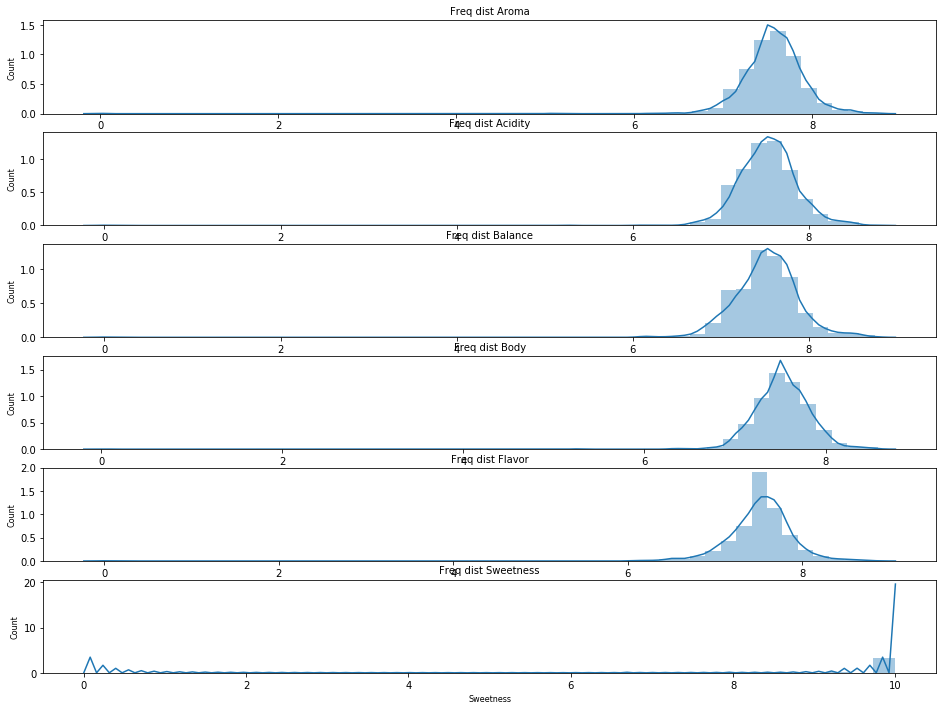

C:\Users\andyh\Anaconda3\envs\miner\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\andyh\Anaconda3\envs\miner\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


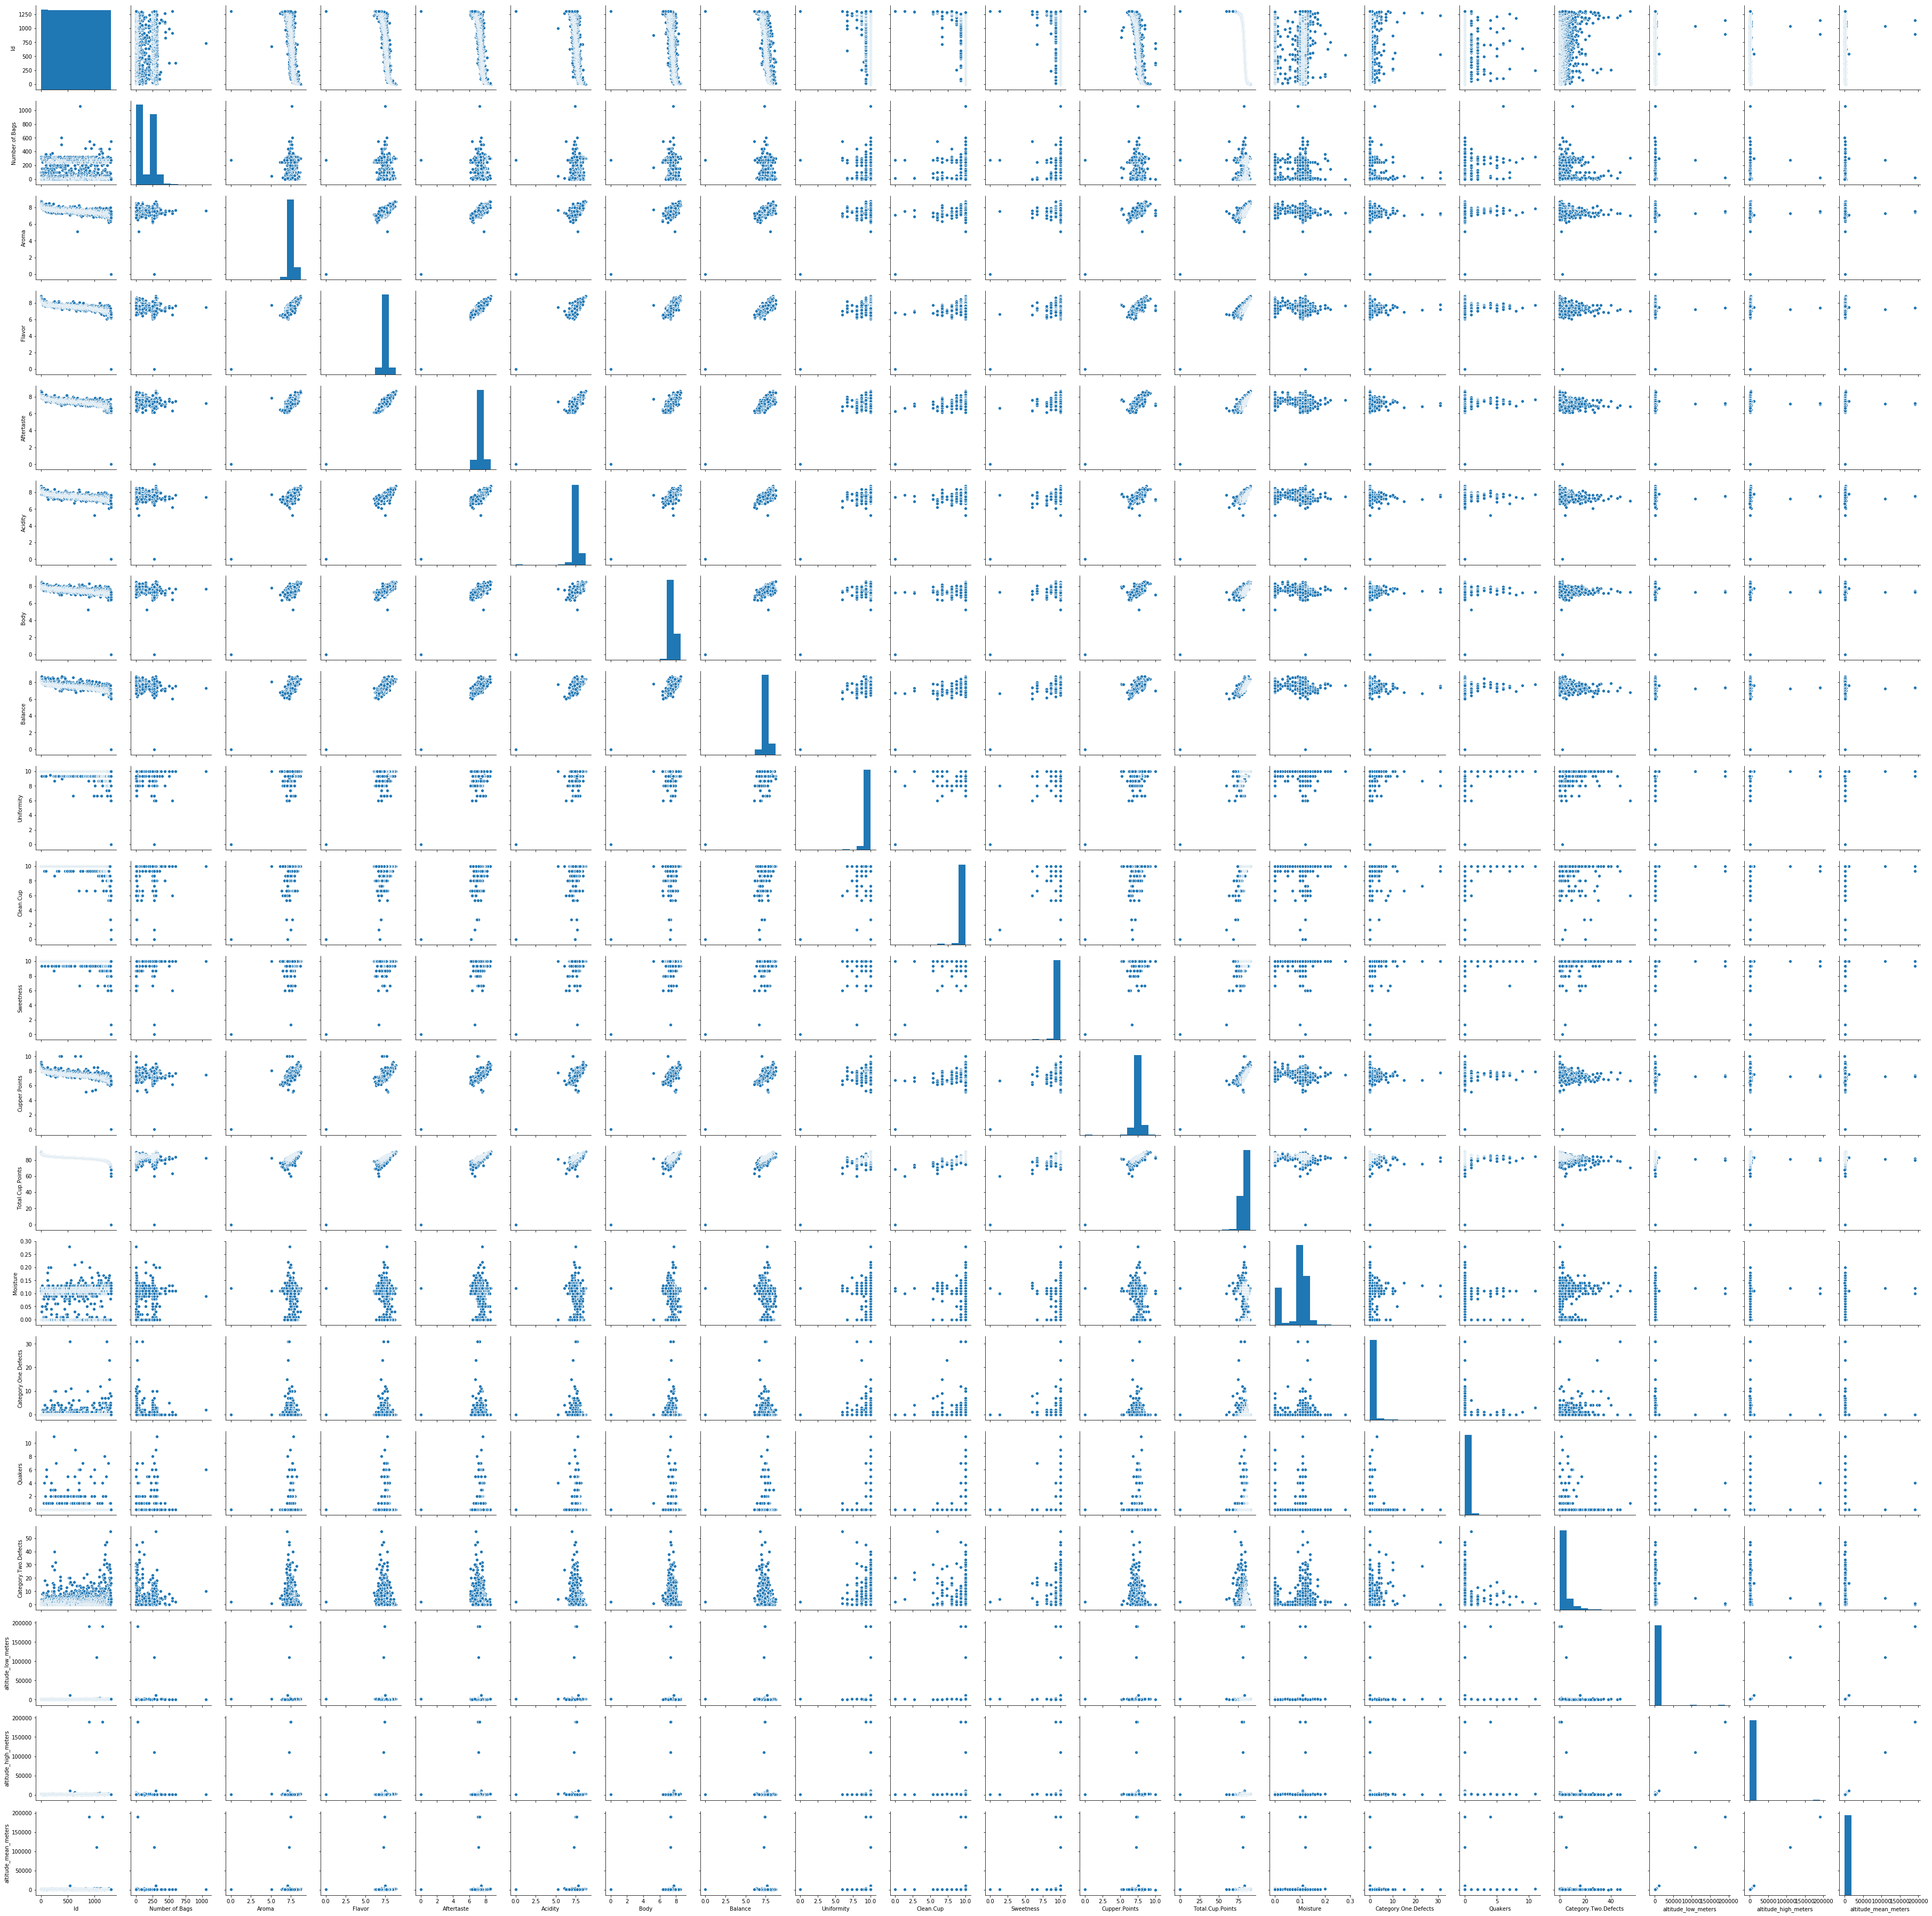

In [25]:
#some initial plots
col_names = ['Aroma','Acidity', 'Balance', 'Body', 'Flavor', 'Sweetness']

fig, ax = plt.subplots(len(col_names), figsize=(16,12))

for i, col_val in enumerate(col_names):

    sns.distplot(df_arab[col_val], hist=True, ax=ax[i])
    ax[i].set_title('Freq dist '+col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

#Huge pairplot matrix.  Probably need to whittle down the attributes a bit first.Example drops below

df_arab = df_arab.drop(['Lot number','Uniformity', 'altitude_low_meters', 'altitude_high_meters'], axis=1)
sns.pairplot(df_arab)

